# Shoot and Go 
## Looking for the right p parameter via Shoot and Go heuristic 

In [1]:
# Import path to source directory (bit of a hack in Jupyter)
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..', 'src')))

# Ensure modules are reloaded on any change (very useful when developing code on the fly)
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#initialization
from objfun_node2vec import N2V
n2v = N2V('../data/clear_cluster_test/one_eighth.csv',
            '../data/clear_cluster_test/labels.csv')

The p parameter is generated randomly within an interval $[0.125,4.125)$.

In [4]:
n2v.generate_point()

3.583162279868077

### 1. Generalized Shoot&Go
 - Shoot & Go heuristic (also known as Iterated Local Search, Random-restart hill climbing, etc)
     - $hmax \in \{ 0, 1, \ldots, \infty \}$ parameter - maximum number of local searches / hill climbs
     - note that $\mathrm{SG}_{0}$ is pure Random Shooting (Random Search)

In [5]:
from heur_sg import ShootAndGo

In [6]:
NUM_RUNS = 50 
maxeval = 50 

### Performance evaluation

In [7]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
import matplotlib.pyplot as plt

#### General experiment setup

Runs selected objective function (of) using selected heuristic multiple times, stores and returns data (results) in a data frame.

In [8]:
def experiment(of, num_runs, hmax, params):
    results = []
    for i in tqdm(range(num_runs), 'Testing hmax = {}'.format(hmax)):
        result = ShootAndGo(of, maxeval=maxeval, hmax=hmax, params=params).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_{}'.format(hmax) # name of the heuristic
        result['hmax'] = hmax
        results.append(result)
    
    # write results to csv file 
    now = datetime.now()
    current_time = now.strftime('%Y%m%d%H%M')
    res = pd.DataFrame(results, columns=['heur', 'run', 'hmax', 'best_x', 'best_y', 'neval'])
    res.to_csv('../results/' + current_time + '_one_eighth_SG_' + str(hmax) + '.csv')
    
    return res

### 2. Node2Vec experiments

- the step is $0.125 (=1/8)$, diameter of the neighborhood $d = 0.125*2$ 

- the $get\_neighborhood()$ function gives 2 left and 2 right neighoors, if possible 

In [11]:
n2v.get_neighborhood(1.0,0.125*2)

array([0.875, 0.75 , 1.125, 1.25 ])

In [9]:
default_params=[1., 10, 80, 10]

In [10]:
def_table = pd.DataFrame()
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]: 
    res = experiment(n2v, maxeval, hmax, default_params)
    def_table = pd.concat([def_table, res], axis=0)

In [11]:
def_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 49
Data columns (total 6 columns):
heur      400 non-null object
run       400 non-null int64
hmax      400 non-null float64
best_x    400 non-null object
best_y    400 non-null float64
neval     400 non-null float64
dtypes: float64(3), int64(1), object(2)
memory usage: 21.9+ KB


In [12]:
def_table.head()

,heur,run,hmax,best_x,best_y,neval
0,SG_0,0,0.0,"[0.3568363958030374, 1.0, 10, 80, 10]",0.892857,inf
1,SG_0,1,0.0,"[0.3879892767910591, 1.0, 10, 80, 10]",0.813953,inf
2,SG_0,2,0.0,"[0.4931101864569012, 1.0, 10, 80, 10]",1.000000,34.0
3,SG_0,3,0.0,"[0.33658288837693684, 1.0, 10, 80, 10]",0.892857,inf
4,SG_0,4,0.0,"[0.3722417123989836, 1.0, 10, 80, 10]",1.000000,37.0


The quality of solutions based on hmax

In [13]:
def_table.groupby(['hmax'])['best_y'].median()

hmax
0.0     1.000000
1.0     0.892857
2.0     0.892857
5.0     0.892857
10.0    0.892857
20.0    0.892857
50.0    0.892857
inf     0.892857
Name: best_y, dtype: float64

In [14]:
def_table.groupby(['hmax'])['best_y'].mean()

hmax
0.0     0.941606
1.0     0.924112
2.0     0.894839
5.0     0.878195
10.0    0.869226
20.0    0.882708
50.0    0.875209
inf     0.882098
Name: best_y, dtype: float64

As __Box-Whiskers plot__:

In [15]:
# import visualization libraries
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<IPython.core.display.Javascript object>


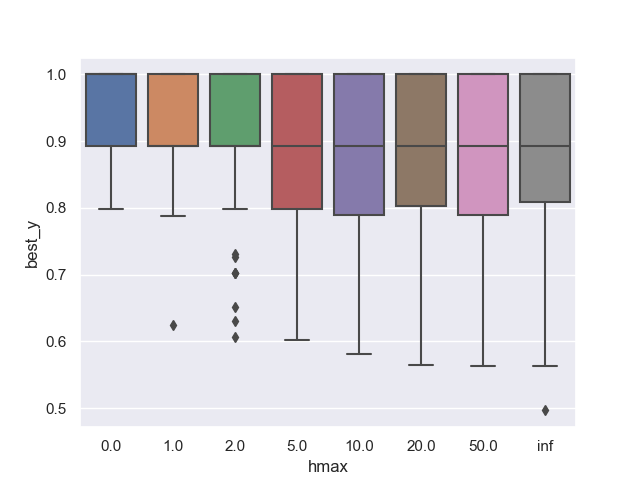

In [32]:
ax = sns.boxplot(x="hmax", y="best_y", data=def_table)

__Number of evaluations (when successful), based on hmax?__

In [17]:
def_table['success'] = def_table['neval'] < np.inf

In [18]:
def_table[def_table['success'] == True].head()

,heur,run,hmax,best_x,best_y,neval,success
2,SG_0,2,0.0,"[0.4931101864569012, 1.0, 10, 80, 10]",1.0,34.0,True
4,SG_0,4,0.0,"[0.3722417123989836, 1.0, 10, 80, 10]",1.0,37.0,True
5,SG_0,5,0.0,"[0.3810893259085075, 1.0, 10, 80, 10]",1.0,13.0,True
7,SG_0,7,0.0,"[0.935380087389496, 1.0, 10, 80, 10]",1.0,39.0,True
9,SG_0,9,0.0,"[0.5140266193977219, 1.0, 10, 80, 10]",1.0,8.0,True


In [19]:
def_table[def_table['success'] == True].groupby(['hmax'])['neval'].mean()

hmax
0.0     22.230769
1.0     23.652174
2.0     23.600000
5.0     19.500000
10.0    19.722222
20.0    23.947368
50.0    25.315789
inf     20.555556
Name: neval, dtype: float64

In [20]:
def_table[def_table['success'] == True].groupby(['hmax'])['neval'].median()

hmax
0.0     21.5
1.0     21.0
2.0     22.5
5.0     19.5
10.0    16.0
20.0    22.0
50.0    25.0
inf     22.5
Name: neval, dtype: float64

<IPython.core.display.Javascript object>


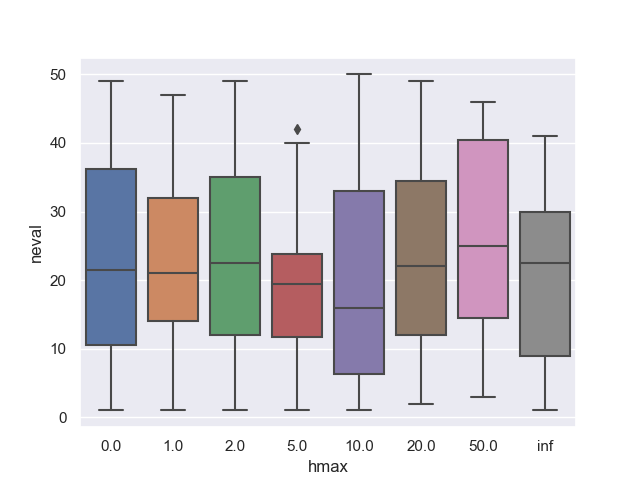

In [33]:
ax = sns.boxplot(x="hmax", y="neval", data=def_table[def_table['success'] == True])

__Reliability__

In [22]:
rel_by_hmax = def_table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: len([n for n in x if n < np.inf])/len(x)
)

In [23]:
rel_by_hmax

,neval
hmax,
0.0,0.52
1.0,0.46
2.0,0.40
5.0,0.32
10.0,0.36
20.0,0.38
50.0,0.38
inf,0.36


<IPython.core.display.Javascript object>


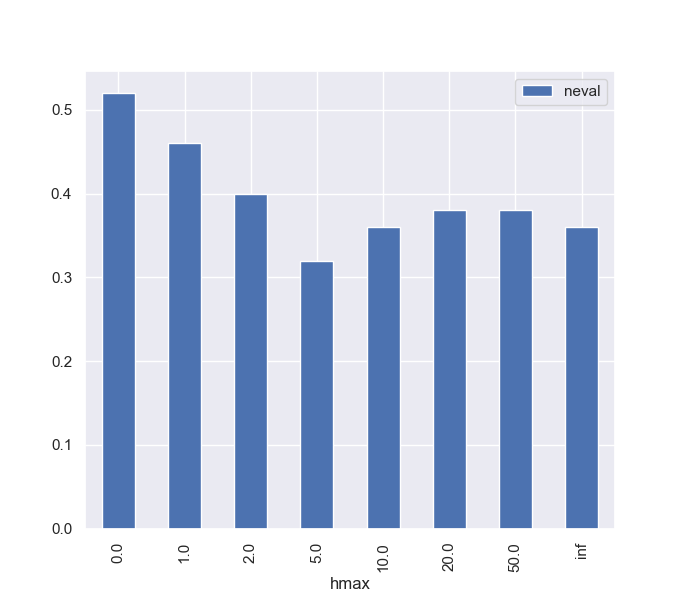

In [35]:
ax = rel_by_hmax.plot(kind='bar')

In [25]:
feo_by_hmax = def_table.pivot_table(
    index=['hmax'],
    values=['neval'],
    aggfunc=lambda x: np.mean([n for n in x if n < np.inf])/(len([n for n in x if n < np.inf])/len(x))
    #                 ^^^   mean number of evaluations ^^^ / ^^^             reliability         ^^^^
)

In [26]:
feo_by_hmax

,neval
hmax,
0.0,42.751479
1.0,51.417769
2.0,59.000000
5.0,60.937500
10.0,54.783951
20.0,63.019391
50.0,66.620499
inf,57.098765


<IPython.core.display.Javascript object>


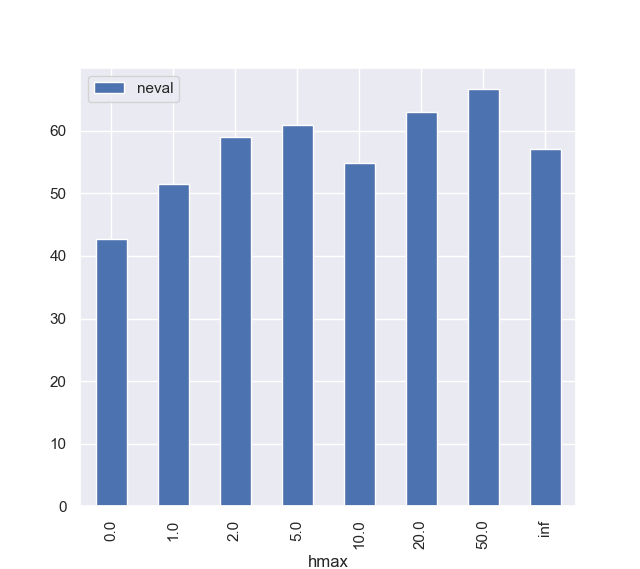

In [36]:
ax = feo_by_hmax.plot(kind='bar')

In [37]:
# performance criteria
def rel(x):
    return len([n for n in x if n < np.inf])/len(x)
def mne(x):
    return np.mean([n for n in x if n < np.inf])
def feo(x):
    return mne(x)/rel(x)

In [38]:
results_pivot = def_table.pivot_table(
    index=['heur', 'hmax'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
results_pivot = results_pivot.reset_index()
results_pivot.sort_values(by='hmax')

,heur,hmax,feo,mne,rel
0,SG_0,0.0,42.751479,22.230769,0.52
1,SG_1,1.0,51.417769,23.652174,0.46
3,SG_2,2.0,59.000000,23.600000,0.40
5,SG_5,5.0,60.937500,19.500000,0.32
2,SG_10,10.0,54.783951,19.722222,0.36
4,SG_20,20.0,63.019391,23.947368,0.38
6,SG_50,50.0,66.620499,25.315789,0.38
7,SG_inf,inf,57.098765,20.555556,0.36


In [56]:
results_pivot.sort_values(by=['feo']).head(8)

,heur,hmax,feo,mne,rel
8,SG_RD_1,1.0,32.934443,20.419355,0.62
0,SG_0,0.0,42.751479,22.230769,0.52
7,SG_RD_0,0.0,44.160000,22.080000,0.50
10,SG_RD_2,2.0,46.021948,24.851852,0.54
14,SG_RD_inf,inf,50.173010,17.058824,0.34
1,SG_1,1.0,51.417769,23.652174,0.46
2,SG_10,10.0,54.783951,19.722222,0.36
15,SG_inf,inf,57.098765,20.555556,0.36


### Random Descent

In [41]:
def experiment_rd(of, num_runs, hmax, params):
    results = []
    for i in tqdm(range(num_runs), 'Testing hmax = {}'.format(hmax)):
        result = ShootAndGo(of, maxeval=maxeval, hmax=hmax, params=params,
                            random_descent=True).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_RD_{}'.format(hmax) # name of the heuristic
        result['hmax'] = hmax
        results.append(result)
    
    # write results to csv file 
    now = datetime.now()
    current_time = now.strftime('%Y%m%d%H%M')
    res = pd.DataFrame(results, columns=['heur', 'run', 'hmax', 'best_x', 'best_y', 'neval'])
    res.to_csv('../results/' + current_time + '_one_eighth_SG_RD' + str(hmax) + '.csv')
    
    return res

In [42]:
for hmax in [0, 1, 2, 5, 10, 20, 50, np.inf]: 
    res = experiment_rd(n2v, maxeval, hmax, default_params)
    def_table = pd.concat([def_table, res], axis=0)

In [43]:
def_table

,best_x,best_y,heur,hmax,neval,run,success
0,"[0.3568363958030374, 1.0, 10, 80, 10]",0.892857,SG_0,0.0,inf,0,False
1,"[0.3879892767910591, 1.0, 10, 80, 10]",0.813953,SG_0,0.0,inf,1,False
2,"[0.4931101864569012, 1.0, 10, 80, 10]",1.000000,SG_0,0.0,34.0,2,True
3,"[0.33658288837693684, 1.0, 10, 80, 10]",0.892857,SG_0,0.0,inf,3,False
4,"[0.3722417123989836, 1.0, 10, 80, 10]",1.000000,SG_0,0.0,37.0,4,True
...,...,...,...,...,...,...,...
45,"[0.3477796293169, 1.0, 10, 80, 10]",1.000000,SG_RD_inf,inf,9.0,45,NaN
46,"[0.5914726364487843, 1.0, 10, 80, 10]",1.000000,SG_RD_inf,inf,37.0,46,NaN
47,"[0.4984238568067303, 1.0, 10, 80, 10]",0.892857,SG_RD_inf,inf,inf,47,NaN
48,"[0.4848334432315933, 1.0, 10, 80, 10]",0.892857,SG_RD_inf,inf,inf,48,NaN


In [48]:
def_table.sort_values(by=['best_y'], ascending=False).head(5)

,best_x,best_y,heur,hmax,neval,run,success
21,"[0.4902902575945314, 1.0, 10, 80, 10]",1.0,SG_10,10.0,36.0,21,True
31,"[1.0056455683367318, 1.0, 10, 80, 10]",1.0,SG_20,20.0,11.0,31,True
3,"[0.38580597424012186, 1.0, 10, 80, 10]",1.0,SG_RD_5,5.0,25.0,3,NaN
43,"[0.21292069377942946, 1.0, 10, 80, 10]",1.0,SG_20,20.0,22.0,43,True
42,"[0.2131932509577057, 1.0, 10, 80, 10]",1.0,SG_20,20.0,42.0,42,True


In [49]:
results_pivot = def_table.pivot_table(
    index=['heur', 'hmax'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
results_pivot = results_pivot.reset_index()
results_pivot.sort_values(by='hmax')

,heur,hmax,feo,mne,rel
0,SG_0,0.0,42.751479,22.230769,0.52
7,SG_RD_0,0.0,44.160000,22.080000,0.50
1,SG_1,1.0,51.417769,23.652174,0.46
8,SG_RD_1,1.0,32.934443,20.419355,0.62
3,SG_2,2.0,59.000000,23.600000,0.40
10,SG_RD_2,2.0,46.021948,24.851852,0.54
5,SG_5,5.0,60.937500,19.500000,0.32
12,SG_RD_5,5.0,73.979592,20.714286,0.28
2,SG_10,10.0,54.783951,19.722222,0.36
9,SG_RD_10,10.0,71.972318,24.470588,0.34


In [51]:
results_pivot.sort_values(by=['feo']).head(5)

,heur,hmax,feo,mne,rel
8,SG_RD_1,1.0,32.934443,20.419355,0.62
0,SG_0,0.0,42.751479,22.230769,0.52
7,SG_RD_0,0.0,44.160000,22.080000,0.50
10,SG_RD_2,2.0,46.021948,24.851852,0.54
14,SG_RD_inf,inf,50.173010,17.058824,0.34


### Neighbourhood diameter

In [71]:
def experiment_diam(of, num_runs, hmax, params, diameter):
    results = []
    for i in tqdm(range(num_runs), 'Testing hmax = {}'.format(hmax)):
        result = ShootAndGo(of, maxeval=maxeval, hmax=hmax, params=params,
                            random_descent=True, diameter=diameter).search() # dict with results of one run
        result['run'] = i
        result['heur'] = 'SG_RD_diam{}'.format(diameter) # name of the heuristic
        result['hmax'] = hmax
        results.append(result)
    
    # write results to csv file 
    now = datetime.now()
    current_time = now.strftime('%Y%m%d%H%M')
    res = pd.DataFrame(results, columns=['heur', 'run', 'hmax', 'best_x', 'best_y', 'neval'])
    res.to_csv('../results/' + current_time + '_one_eighth_SG_RD_diam' + str(diameter) + '.csv')
    
    return res

In [72]:
for diameter in [0.125,0.25,0.5,0.75]: 
    res = experiment_diam(n2v, maxeval, 1, default_params,diameter)
    def_table = pd.concat([def_table, res], axis=0)

In [73]:
def_table.sort_values(by=['heur'], ascending=False).head(5)

,best_x,best_y,heur,hmax,neval,run,success
0,"[0.4913898670546595, 1.0, 10, 80, 10]",1.000000,SG_inf,inf,24.0,0,True
25,"[0.9136898705756815, 1.0, 10, 80, 10]",0.777344,SG_inf,inf,inf,25,False
27,"[0.514012283097204, 1.0, 10, 80, 10]",1.000000,SG_inf,inf,38.0,27,True
28,"[0.5783904387151915, 1.0, 10, 80, 10]",0.892857,SG_inf,inf,inf,28,False
29,"[0.6011619843555644, 1.0, 10, 80, 10]",1.000000,SG_inf,inf,7.0,29,True


In [74]:
results_pivot = def_table.pivot_table(
    index=['heur', 'hmax'],
    values=['neval'],
    aggfunc=(rel, mne, feo)
)['neval']
results_pivot = results_pivot.reset_index()
results_pivot.sort_values(by='hmax')

,heur,hmax,feo,mne,rel
0,SG_0,0.0,42.751479,22.230769,0.520
7,SG_RD_0,0.0,44.160000,22.080000,0.500
1,SG_1,1.0,51.417769,23.652174,0.460
17,SG_RD_diam0.75,1.0,36.008230,19.444444,0.540
16,SG_RD_diam0.5,1.0,39.780521,21.481481,0.540
15,SG_RD_diam0.25,1.0,29.726516,17.241379,0.580
8,SG_RD_1,1.0,32.934443,20.419355,0.620
14,SG_RD_diam0.125,1.0,33.102041,23.171429,0.700
3,SG_2,2.0,59.000000,23.600000,0.400
10,SG_RD_2,2.0,46.021948,24.851852,0.540


In [75]:
results_pivot.sort_values(by=['feo']).head(5)

,heur,hmax,feo,mne,rel
15,SG_RD_diam0.25,1.0,29.726516,17.241379,0.58
8,SG_RD_1,1.0,32.934443,20.419355,0.62
14,SG_RD_diam0.125,1.0,33.102041,23.171429,0.70
17,SG_RD_diam0.75,1.0,36.008230,19.444444,0.54
16,SG_RD_diam0.5,1.0,39.780521,21.481481,0.54


In [76]:
def_table['best_y'].mean()

0.9044256888046154

In [77]:
def_table['best_y'].median()

0.8928571428571429

In [78]:
def_table['best_y'].mode()

0    1.0
dtype: float64

In [79]:
def_table['best_y'].max()

1.0

## Conclusion

- According to the Feoktistov criterion, the most reliable in this case was the Random
shooting algorithm, i.e. $hmax = 0$ setting with $FEO = 42:75$.
- Repeating of the algorithm with Random Descent parameter improved reliability of
the result by almost 10. 
- By the neighbourhood diameter examination
no improvements were achieved.